# IMPORTS

In [108]:
import os, sys, git, time, ntpath, tracemalloc, sqlite3, pandas as pd, numpy as np
from pandas.api.types import CategoricalDtype
from scripts.log_processing.plotting import *
# from scripts.log_processing import data_loader as loader

# DO NOT IMPORT IN REAL SCRIPT:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display


%matplotlib widget

# DEFAULT PLOTTING THEMES

In [175]:
theme_default = theme (
    plot_title = element_text(size = 17),
    axis_title = element_text(size = 17),
    legend_title = element_text(size = 17),
    legend_text = element_text(size = 12)
)
theme_set(theme_default)

# Functions

In [109]:
def lastEpisode(configs, sample_rate):
    num_episodes = configs['numEpisodes'].max() / configs['numStartingPositions'].max()
    last_episode = -sample_rate % num_episodes
    return last_episode

def getDataEpisodeAndSummaries(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET SUMMARIZED RUNTIME DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location), configs, fields_to_add)

    # GET EPISODE DATA:
    runtimes_episode = None if skip_runtimes else augment_data(load_episode_runtimes(db, indices, location, episode), configs, fields_to_add)
            
    return summaries, runtimes_episode

def getLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_all_runtimes_smaller_than_threshold(db, indices, location, threshold)  
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

def augment_data(data, configs, fields):
    return pd.merge(data, configs[ ['c_id'] + fields ], left_on='config', right_on='c_id', how='left')
    

# SET EXPERIMENT AND LOAD DATABASE

In [110]:
folder = 'experiments/BICY2020_modified/logs/experiment11-article2/'
figure_folder = folder + 'figures/'
make_folder(figure_folder)

git_root = './'
layers_folder = 'experiments/pc_layers/'
layer_metrics_file = os.path.join(git_root, layers_folder + 'layer_metrics.csv')

sample_rate = 5
db = sqlite3.connect(folder + 'experiment_results.sqlite')


In [209]:
min_layers = ['u04_40', 'u08_21', 'u12_14', 'u16_11', 'u20_09', 'u24_07', 'u28_06', 'u32_06', 'u36_06', 'u40_05', 'u44_05', 'u48_04', 'u52_04', 'u56_04']

# ADD COLUMNS TO CONFIGS
configs = load_config_file(folder)
configs['c_id'] = configs.index.map(lambda v : int(v[1:]))
configs['pc_files'] = configs.pc_files.map(os.path.normpath )
configs['pcs'] = configs.pc_files.map(lambda v : ntpath.basename(v)[0:-4])
configs['maze']= configs.mazeFile.map(lambda v : ntpath.basename(v)[0:-4])

# GET LAYER METRICS 
layer_metrics = pd.read_csv(layer_metrics_file)
layer_metrics['layer'] = layer_metrics.layer.map(lambda l : os.path.normpath(layers_folder + l) ) # normalize path and prepend location
layer_metrics['simple_name'] = layer_metrics.layer.map(lambda l : os.path.basename(l) )
layer_metrics['normalized mean distance density'] = 1 / layer_metrics['normalized mean distance']
layer_metrics['normalized coverage'] = layer_metrics['coverage'] * layer_metrics['number of cells']
layer_metrics['num_cells'] = layer_metrics['number of cells']

# f'CONFIG COLUMNS {configs.columns.values}', 'CONFIGS:', configs, 'LAYER METRICS:', layer_metrics
display(configs)
display(layer_metrics)

,experiment,group,mazeFile,numStartingPositions,pc_files,traces,numEpisodes,c_id,pcs,maze
config,,,,,,,,,,
c0,experiments/setups/experiment_1.xml,g1,M0.xml,7,experiments\pc_layers\uniform\u04_40.csv,0.0,70000,0,u04_40,M0
c1,experiments/setups/experiment_1.xml,g1,M0.xml,7,experiments\pc_layers\uniform\u04_40.csv,0.7,70000,1,u04_40,M0
c2,experiments/setups/experiment_1.xml,g1,M0.xml,7,experiments\pc_layers\uniform\u08_21.csv,0.0,70000,2,u08_21,M0
c3,experiments/setups/experiment_1.xml,g1,M0.xml,7,experiments\pc_layers\uniform\u08_21.csv,0.7,70000,3,u08_21,M0
c4,experiments/setups/experiment_1.xml,g1,M0.xml,7,experiments\pc_layers\uniform\u08_25.csv,0.0,70000,4,u08_25,M0
...,...,...,...,...,...,...,...,...,...,...
c13159,experiments/setups/experiment_1.xml,g1,M607.xml,4,experiments\pc_layers\multi_layer\ml_4_16_52.csv,0.7,40000,13159,ml_4_16_52,M607
c13160,experiments/setups/experiment_1.xml,g1,M608.xml,4,experiments\pc_layers\multi_layer\ml_4_16_52.csv,0.0,40000,13160,ml_4_16_52,M608
c13161,experiments/setups/experiment_1.xml,g1,M608.xml,4,experiments\pc_layers\multi_layer\ml_4_16_52.csv,0.7,40000,13161,ml_4_16_52,M608


,layer,number of cells,total area,mean area,mean radius,mean distance,normalized mean distance,coverage,simple_name,normalized mean distance density,normalized coverage,num_cells
0,experiments\pc_layers\locally_uniform\lu0_20_1...,126,15.426477,0.122432,0.197143,1.502259,7.620153,1.931590,lu0_20_16.csv,0.131231,243.380355,126
1,experiments\pc_layers\locally_uniform\lu0_24_1...,79,13.390725,0.169503,0.230886,1.537851,6.660649,1.584301,lu0_24_16.csv,0.150136,125.159817,79
2,experiments\pc_layers\locally_uniform\lu0_28_1...,63,14.024070,0.222604,0.262857,1.556019,5.919638,1.596487,lu0_28_16.csv,0.168929,100.578684,63
3,experiments\pc_layers\locally_uniform\lu0_32_1...,63,18.095574,0.287231,0.297143,1.556019,5.236603,2.053446,lu0_32_16.csv,0.190964,129.367085,63
4,experiments\pc_layers\locally_uniform\lu0_36_1...,63,22.709945,0.360475,0.331429,1.556019,4.694885,2.571332,lu0_36_16.csv,0.212998,161.993939,63
...,...,...,...,...,...,...,...,...,...,...,...,...
122,experiments\pc_layers\uniform\u56_20.csv,560,551.713935,0.985203,0.560000,1.424010,2.542874,65.843517,u56_20.csv,0.393256,36872.369518,560
123,experiments\pc_layers\uniform\u56_25.csv,875,862.053024,0.985203,0.560000,1.411379,2.520319,103.768336,u56_25.csv,0.396775,90797.294224,875
124,experiments\pc_layers\uniform\u56_30.csv,1230,1211.800251,0.985203,0.560000,1.403663,2.506540,146.620107,u56_30.csv,0.398956,180342.732152,1230
125,experiments\pc_layers\uniform\u56_35.csv,1680,1655.141806,0.985203,0.560000,1.397716,2.495921,201.059767,u56_35.csv,0.400654,337780.409285,1680


# Experiment 11

## Locally uniform experiment

In [5]:
# CHOOSE PARAMETERS
mazes = ['M0', 'M1']
traces = [0 ,0.7]
m = mazes[1]
t = traces[0]

# CREATE FOLDERS FOR EXPERIMENT
folder_lu = os.path.join(figure_folder,'locally_uniform/')
folder_lu_runtimes = os.path.join(folder_lu, 'runtimes/')
make_folder(folder_lu)
make_folder(folder_lu_runtimes)


# GENERATE CATEGORIES FOR DATA
categories = ['original', 'goal', 'goal and gap']
categories = CategoricalDtype(categories[0:-1] if m == 'M0' else categories , ordered=True)

# GET CONFIGS RELEVANT TO EXPERIMENT
experiment_configs = configs[ configs.mazeFile.str.contains(m + '.xml') & ( configs.traces == t ) & configs.pc_files.str.contains('|'.join(['lu'] + min_layers[4:])) ].copy()
experiment_configs['base layer'] = experiment_configs.pcs.map(lambda l : re.findall('\d+', l)[-2])
experiment_configs['legend groups'] = experiment_configs.pcs.map(lambda l : 'original' if l[0]=='u' else 'goal' if l[2] == '0' else 'goal and gap').astype(categories)

# GET AND AUGMENT DATA
merge_fields = ['base layer', 'legend groups']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)


# DISPLAY
# display('CATEGORIES: ', categories)
# display(experiment_configs[['mazeFile','pcs','traces','base layer','legend groups']])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)

,config,location,rat,episode,steps,c_id,base layer,legend groups
0,246,255,0,105,0.959831,246,20,original
1,246,255,1,90,0.871313,246,20,original
2,246,255,2,100,0.859128,246,20,original
3,246,255,3,95,0.880654,246,20,original
4,246,255,4,110,0.841338,246,20,original
...,...,...,...,...,...,...,...,...
2995,13036,255,95,70,0.622612,13036,56,goal and gap
2996,13036,255,96,45,0.994797,13036,56,goal and gap
2997,13036,255,97,50,0.670591,13036,56,goal and gap
2998,13036,255,98,45,0.686328,13036,56,goal and gap


In [8]:
# PLOT FUNCTIONS

def plot_grouped_box_plot(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, ylim):
    p0 = ggplot(data, aes(x_column, y_column, fill=fill_column ))
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(dodge_width=0.75), mapping=aes(group=fill_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=legend_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    p0 += scale_fill_brewer(type="qual", palette=1)
    p0 += coord_cartesian(ylim=ylim)              
    return p0

def plot_time_series(data, x_column, y_column, color_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=color_column))
    p0 += geom_line()
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_brewer(type="qual", palette=1) 
    return p0


# plt.close('all')

# PLOT BOXPLOT
group_name = f'{m}'
plot_title = f'Maze {m[1:]} - Trace {t}'
ylim = [0, 1]
box_plot = plot_grouped_box_plot(runtimes_last_episode, 'base layer', 'steps', 'legend groups', 'Base Layer', 'Extra Steps', 'Group', plot_title, ylim)
# ggsave(box_plot, folder_lu + f'Boxplots-{m}-T{int(t*10)}-l{ylim[1]}.pdf', dpi=300, verbose = False)


# PLOT LEAR TIME
group_name = f'{m}'
plot_title = f'Maze {m[1:]} - Trace {t}'
ylim = [0, 250]
learn_time_plot = plot_grouped_box_plot(learning_times, 'base layer', 'episode', 'legend groups', 'Base Layer', 'Episodes', 'Group', plot_title, ylim)
# ggsave(learn_time_plot, folder_lu + f'Learn_time-{m}-T{int(t*10)}-l{ylim[1]}-Th{threshold}.pdf', dpi=300, verbose = False)




# PLOT RUNTIME - ONLY ONE BASE LAYER PER PLOT
base_layer = '24'
plot_data = summaries[summaries['base layer']==base_layer]

group_name = f'{m}'
plot_title = f'Maze {m[1:]} - Trace {t} - Base layer {base_layer}'
xlim = [0, 500]
ylim = [0, 1]

save_name = folder_lu_runtimes + f'runtimes-{m}-T{int(t*10)}-L{base_layer}-y{ylim[1]}-x{xlim[1]}.pdf'
print(f'    Plot layer: {base_layer}   -   file: {ntpath.basename(save_name)}')
runtime_plot = plot_time_series(plot_data, 'episode', 'steps', 'legend groups', 'Episode', 'Extra Steps', 'Group', plot_title, xlim, ylim )
# ggsave(runtime_plot, save_name, dpi=300, verbose = False)

display(learn_time_plot)
display(box_plot)
display(runtime_plot)

    Plot layer: 24   -   file: runtimes-M1-T0-L24-y1-x500.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (94071520127)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (93955173629)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (93955342340)>

## Non uniform experiment

In [55]:
# CHOOSE PARAMETERS
m = 'M8'  # M0, M1, M8
t = 0.7     # 0 , 0.7

# CREATE FOLDERS FOR EXPERIMENT
folder_nu = os.path.join(figure_folder,'non_uniform/')
# folder_nu_runtimes = os.path.join(folder_nu, 'runtimes/')
make_folder(folder_nu)
# make_folder(folder_nu_runtimes)


# GET CONFIGS RELEVANT TO EXPERIMENT
experiment_configs = configs[ configs.mazeFile.str.contains(m + '.xml') & ( configs.traces == t ) & configs.pc_files.str.contains('|'.join(['non_uniform'] + min_layers)) ].copy()
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')

# add column layer alias
alias = lambda l : l[0:3] if l[0] == 'u' else 'nu'
cells = lambda r : r['number of cells']
alias_column = experiment_configs.apply( lambda r : f'{alias(r["pcs"])} ({cells(r)})' , axis = 1 )
aliases = list(alias_column.values)
aliases = [aliases[-1]] + aliases[0:-1]
aliases2 = sorted(aliases, key = lambda v : int(re.search(r'\((\d+)\)', v).group(1)), reverse=True )
for i in range(len(aliases2)):
    if 'nu' in aliases2[i]:
        position = i
        break
experiment_configs['layer_alias'] = alias_column.astype(CategoricalDtype(aliases, ordered=True))
experiment_configs['layer_alias2'] = alias_column.astype(CategoricalDtype(aliases2, ordered=True))


# GET AND AUGMENT DATA
merge_fields = ['layer_alias', 'layer_alias2']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['mazeFile','traces','pcs', 'layer_alias']
# display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)


,config,location,rat,episode,steps,c_id,layer_alias,layer_alias2
0,413,255,0,1630,0.766925,413,u04 (2200),u04 (2200)
1,413,255,1,1630,0.804062,413,u04 (2200),u04 (2200)
2,413,255,2,1295,0.898210,413,u04 (2200),u04 (2200)
3,413,255,3,1490,0.791374,413,u04 (2200),u04 (2200)
4,413,255,4,1485,0.881514,413,u04 (2200),u04 (2200)
...,...,...,...,...,...,...,...,...
1495,13043,255,95,70,0.567065,13043,nu (128),nu (128)
1496,13043,255,96,60,0.602150,13043,nu (128),nu (128)
1497,13043,255,97,105,0.970975,13043,nu (128),nu (128)
1498,13043,255,98,50,0.862778,13043,nu (128),nu (128)


In [56]:
# BOXPLOT FUNCTION

def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += labs(x=x_title, y=y_title, title=plot_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=1))
    p0 += coord_cartesian(ylim=ylim)              
    return p0

def plot_time_series(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    p0 += geom_line()
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_discrete()
    return p0


# plt.close('all')

# PLOT BOXPLOTS
maze_num = '2' if '8' in m else m[1:]
plot_title = f'Maze {maze_num} - Trace {t}'
lims = [0, 1]
box_plot_colors = ['black' for i in range(len(aliases))]
box_plot_colors[position] = 'red'

save_name = f'Boxplots-{m}-T{int(t*10)}-l{lims[1]}.pdf'
print(f'      PLOT: BOXPLOT - {save_name}')
box_plot = plot_box_plot(runtimes_last_episode, 'layer_alias2', 'steps', 'Layer', 'Extra Steps', plot_title, lims, box_plot_colors)
ggsave(box_plot, folder_nu + save_name, dpi=300, verbose = False)



# PLOT LEARN TIME
lims = [0, 1000]
save_name = f'Learn_time-{m}-T{int(t*10)}-l{lims[1]}-Th{threshold}.pdf'
print(f'      PLOT: BOXPLOT - {save_name}')
learn_time_plot = plot_box_plot(learning_times, 'layer_alias2', 'episode', 'Layer', 'Episodes', plot_title, lims, box_plot_colors)
ggsave(learn_time_plot, folder_nu + save_name, dpi=300, verbose = False)


# PLOT RUN TIMES
plot_title = f'Maze {m[1:]} - Trace {t}'
ylims = [0, 1]
xlims = [0, 10000]


save_name = f'runtimes-{m}-T{int(t*10)}-y{ylims[1]}-x{xlims[1]}.pdf'
print(f'      PLOT: RUNTIME - {save_name}')
runtime_plot = plot_time_series(summaries, 'episode', 'steps' , 'layer_alias', 'Episode', 'Extra Steps', 'Group', plot_title , xlims, ylims )
# ggsave(runtime_plot, folder_nu_runtimes + save_name, dpi=300, verbose = False)

# DISPLAY
display(box_plot)
display(learn_time_plot)
display(runtime_plot)

      PLOT: BOXPLOT - Boxplots-M8-T7-l1.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      PLOT: BOXPLOT - Learn_time-M8-T7-l1000-Th1.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      PLOT: RUNTIME - runtimes-M8-T7-y1-x10000.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135870117720)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135972586307)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135968442808)>

## Density Experiment - Learning time in first episode vs num obstacles

In [34]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]

# CREATE FOLDERS FOR EXPERIMENT
folder_first_episode = os.path.join(figure_folder, 'density_first_episode/')
make_folder(folder_first_episode)


# GET RELEVANT CONFIGS
# keep mazes with varying number of obstacles only (all but M1 and M8), and get only layer 04 wutg traces 0
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == 'u04') & (configs.traces == 0)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10).astype('category')


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles']
episode = 0
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location, skip_summary=True)

from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn as dunn_test
k = kruskal(*[group["steps"].values for name, group in runtimes_last_episode.groupby("num_obstacles")])
dunn = dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
dunn2 = dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust='fdr_bh', sort = False)
display(f'stat: {k}')
display(dunn, dunn2)

# DISPLAY
# display(experiment_configs)
# display(runtimes_last_episode)


'stat: KruskalResult(statistic=35.15649610760147, pvalue=4.01883190085599e-06)'

,0,10,20,30,40,50,60
0,1.000000,1.000000,1.000000,0.009139,0.861758,0.002864,0.000208
10,1.000000,1.000000,1.000000,0.154963,1.000000,0.061306,0.007196
20,1.000000,1.000000,1.000000,0.206899,1.000000,0.084084,0.010434
30,0.009139,0.154963,0.206899,1.000000,1.000000,1.000000,1.000000
40,0.861758,1.000000,1.000000,1.000000,1.000000,1.000000,0.367473
50,0.002864,0.061306,0.084084,1.000000,1.000000,1.000000,1.000000
60,0.000208,0.007196,0.010434,1.000000,0.367473,1.000000,1.000000


,0,10,20,30,40,50,60
0,1.000000,0.468691,0.453772,0.002087,0.078342,0.001432,0.000208
10,0.468691,1.000000,0.921726,0.019370,0.342514,0.010218,0.002087
20,0.453772,0.921726,1.000000,0.022989,0.375987,0.012012,0.002087
30,0.002087,0.019370,0.022989,1.000000,0.226675,0.804889,0.453772
40,0.078342,0.342514,0.375987,0.226675,1.000000,0.133846,0.036747
50,0.001432,0.010218,0.012012,0.804889,0.133846,1.000000,0.602866
60,0.000208,0.002087,0.002087,0.453772,0.036747,0.602866,1.000000


In [35]:
def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += labs(x=x_title, y=y_title, title=plot_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=1))
    p0 += coord_cartesian(ylim=ylim)              
    return p0

lims = [0, 100]
box_plot = plot_box_plot(runtimes_last_episode, 'num_obstacles', 'steps', 'Obstacles', 'Extra Steps', "First trial extra steps", lims, 'black')
ggsave(box_plot, folder_first_episode + 'first_episode.pdf', dpi=300, verbose = False)

display(box_plot)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135960776430)>

## Density experiment - fixed number of obstacles

In [7]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]
layers = [f'u{4*i:02d}' for i in range(1,15)]
traces = [0, 0.7]

o = num_obstacles[0]
t = traces[0]
l = layers[1]

# CREATE FOLDERS FOR EXPERIMENT
folder_density_obstacle_num = os.path.join(figure_folder, 'density_fixed_obstacle_num/')
make_folder(folder_density_obstacle_num)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')
experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale % 8 == 0)]


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# display(experiment_configs['number of cells'].unique())
display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)



,c_id,maze,num_obstacles,pcs,scale,number of cells
config,,,,,,
c2,2,M0,0,u08_21,8,609
c4,4,M0,0,u08_25,8,875
c6,6,M0,0,u08_30,8,1230
c8,8,M0,0,u08_35,8,1680
c10,10,M0,0,u08_40,8,2200
c26,26,M0,0,u16_11,16,165
c28,28,M0,0,u16_15,16,315
c30,30,M0,0,u16_20,16,560
c32,32,M0,0,u16_25,16,875


,config,location,rat,episode,steps,c_id,num_obstacles,scale,number of cells
0,2,255,0,390,0.976939,2,0,8,609
1,2,255,1,445,0.934271,2,0,8,609
2,2,255,2,440,0.982514,2,0,8,609
3,2,255,3,485,0.881655,2,0,8,609
4,2,255,4,455,0.941172,2,0,8,609
...,...,...,...,...,...,...,...,...,...
5395,204,255,95,1615,0.988743,204,0,56,2200
5396,204,255,96,2190,0.994204,204,0,56,2200
5397,204,255,97,2125,0.850401,204,0,56,2200
5398,204,255,98,2100,0.992019,204,0,56,2200


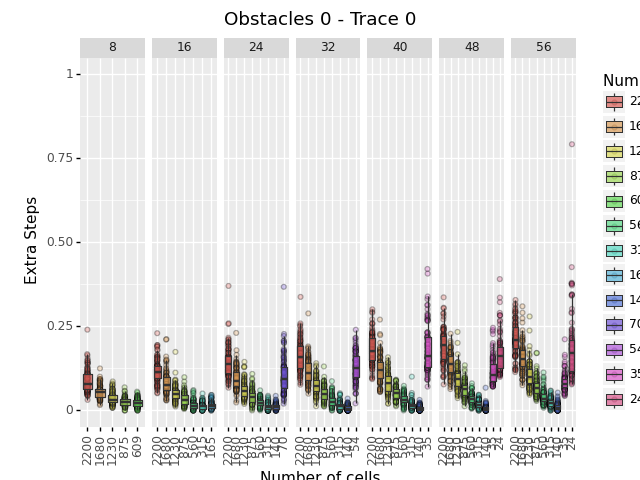

<ggplot: (146195772194)>

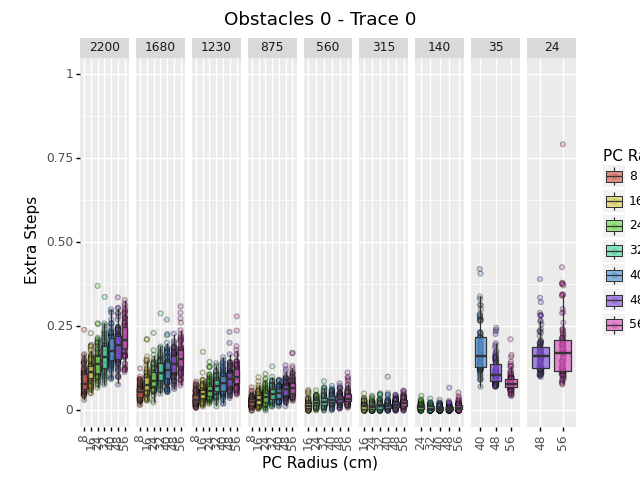

<ggplot: (146172450012)>

In [ ]:
folder_density_obstacle_num = os.path.join(figure_folder, 'density_fixed_obstacle_num/test/')
make_folder(folder_density_obstacle_num)

# BOXPLOT FUNCTION
def plot_faceted_box_plot(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
    p0 += facet_grid(f'. ~ {facet_column}', scales='free')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# plt.close('all')

# PLOT BOXPLOTS SCALE
plot_title = f'Obstacles {o} - Trace {t}'
lims = [0, 1]
save_name = f'Boxplots_Scale-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

r2 = runtimes_last_episode[runtimes_last_episode.scale > 4].copy()
r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
box_plot_scale = plot_faceted_box_plot(r2, 'num_cells', 'steps', 'scale_d', 'Number of cells', 'Extra Steps' , plot_title, lims)
# ggsave(box_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME SCALE
lims = [0, 5000]
save_name = f'Learn_time_Scale-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

learn_times_2 = learning_times[learning_times.scale > 4].copy()
learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
learn_times_2['scale_d'] = pd.Categorical(learn_times_2['scale'], np.sort(learn_times_2['scale'].unique())) 

learn_time_plot_scale = plot_faceted_box_plot(learn_times_2, 'num_cells', 'episode', 'scale_d', 'Number of Cells', 'Episodes' , plot_title, lims)      
# ggsave(learn_time_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT BOXPLOT CELLS
lims = [0, 1]
save_name = f'Boxplots_Cells-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = runtimes_last_episode['number of cells'].value_counts()
filtered_runtimes = runtimes_last_episode[runtimes_last_episode['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_runtimes['num_cells'] = pd.Categorical(filtered_runtimes['number of cells'], np.sort(filtered_runtimes['number of cells'].unique())[::-1])
filtered_runtimes['scale_d'] = pd.Categorical(filtered_runtimes['scale'], np.sort(filtered_runtimes['scale'].unique())) 

box_plot_cells = plot_faceted_box_plot(filtered_runtimes, 'scale_d', 'steps', 'num_cells', 'PC Radius (cm)', 'Extra Steps' , plot_title, lims)
# ggsave(box_plot_cells, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME CELLS
lims = [0, 5000]
save_name = f'Learn_Time_Cells-O{o}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = learning_times['number of cells'].value_counts()
filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_learn_times['num_cells'] = pd.Categorical(filtered_learn_times['number of cells'], np.sort(filtered_learn_times['number of cells'].unique())[::-1])
filtered_learn_times['scale_d'] = pd.Categorical(filtered_learn_times['scale'], np.sort(filtered_learn_times['scale'].unique())) 

learn_time_plot_cells = plot_faceted_box_plot(filtered_learn_times, 'scale_d', 'episode', 'num_cells', 'PC Radius (cm)', 'Episodes', plot_title, lims)
# ggsave(learn_time_plot_cells, folder_density_obstacle_num + save_name, dpi=300, verbose = False, width = 10, height =5)

display(box_plot_scale)
# display(learn_time_plot_scale)
display(box_plot_cells)
# display(learn_time_plot_cells)


## Density experiment - density

Non-uniform,simple_name,number of cells,coverage
21,non_uniform_0.csv,38,1.700507
22,non_uniform_1.csv,79,1.582712
23,non_uniform_8.csv,128,1.551667


Multiscale uniform,simple_name,number of cells,coverage
20,ml_4_16_52.csv,2389,5.240555


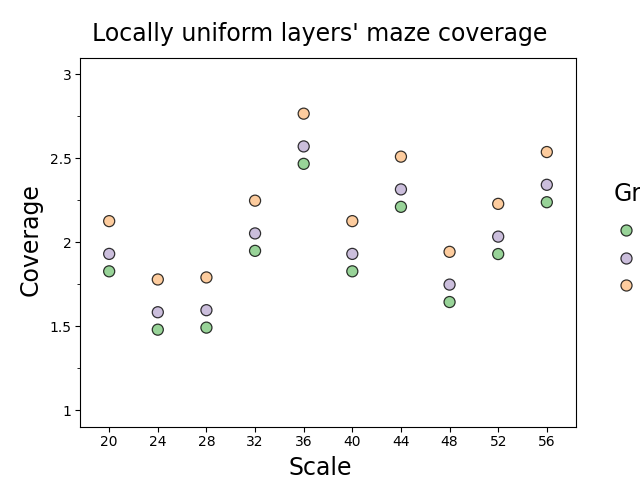

<ggplot: (146118787193)>

In [241]:
# PLOT LAYER DENSITIES
metric = 'coverage'

# GET LAYER METRICS OF EACH LAYER TYPE
uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'u') ].copy()
locally_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'l' or (v[0:-4] in min_layers[4:14]))].copy()
non_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'n') ].copy()
multiscale_uniform_layer_metrics = layer_metrics[ layer_metrics.simple_name.map(lambda v : v[0] == 'm') ].copy()

                                                                             
# PREPARING UNIFOR METRIC FIELDS
uniform_layer_metrics['scale'] = uniform_layer_metrics.simple_name.map(lambda v : int(v[1:3]))
locally_uniform_layer_metrics['scale'] = locally_uniform_layer_metrics.simple_name.map(lambda v : int(v[4:6]) if v[0]=='l' else int(v[1:3]))
categories =  CategoricalDtype(['original', 'goal', 'goal and gap'] , ordered=True)
locally_uniform_layer_metrics['group'] = locally_uniform_layer_metrics.simple_name.map(lambda l : 'original' if l[0]=='u' else 'goal' if l[2] == '0' else 'goal and gap').astype(categories)



# DISPLAY DATA
uniform_layer_metrics.columns.name = "Uniform"
non_uniform_layer_metrics.columns.name = "Non-uniform"
locally_uniform_layer_metrics.columns.name = "Locally uniform"
multiscale_uniform_layer_metrics.columns.name = "Multiscale uniform"
# display(uniform_layer_metrics)
# display(locally_uniform_layer_metrics)
display(non_uniform_layer_metrics[['simple_name','number of cells', 'coverage']])
display(multiscale_uniform_layer_metrics[['simple_name','number of cells', 'coverage']])

# PLOT UNIFORM
p0 = ggplot(uniform_layer_metrics, aes('factor(scale)', 'coverage', fill = 'factor(num_cells)' ))
p0 += geom_point(size=4, alpha=0.5)
p0 += labs(x='Scale', y='Coverage', fill='Cells', title='Uniform layers\' maze coverage') # fill = x_title
p0 += coord_cartesian(ylim=[1,300])

ggsave(p0, figure_folder + 'coverage_per_layer.pdf', dpi=300, verbose = False, width = 6, height =5)

# PLOT LOCALLY UNIFORM
p1 = ggplot(locally_uniform_layer_metrics, aes('factor(scale)', 'coverage', fill = 'group' ))
p1 += geom_point(size=4, alpha=0.8)
p1 += labs(x='Scale', y='Coverage', fill='Group', title='Locally uniform layers\' maze coverage') # fill = x_title
p1 += scale_fill_brewer(type="qual", palette=1)
p1 += coord_cartesian(ylim=[1,3])

ggsave(p1, figure_folder + 'coverage_per_layer_locally_uniform.pdf', dpi=300, verbose = False, width = 6, height =5)


# DISPLAY PLOTS:
# display(p0)
display(p1)




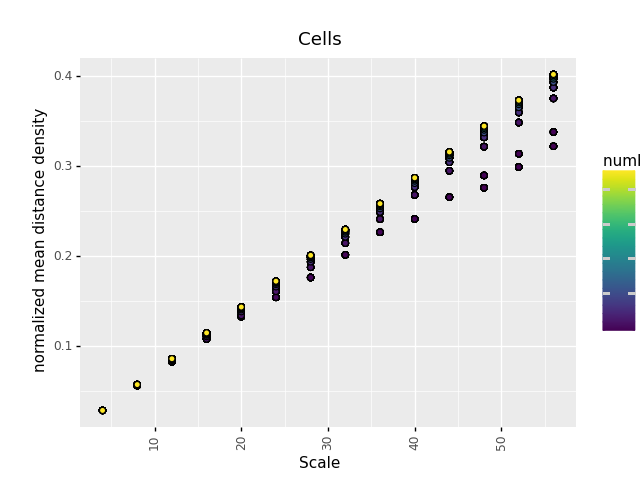

<ggplot: (146108149818)>

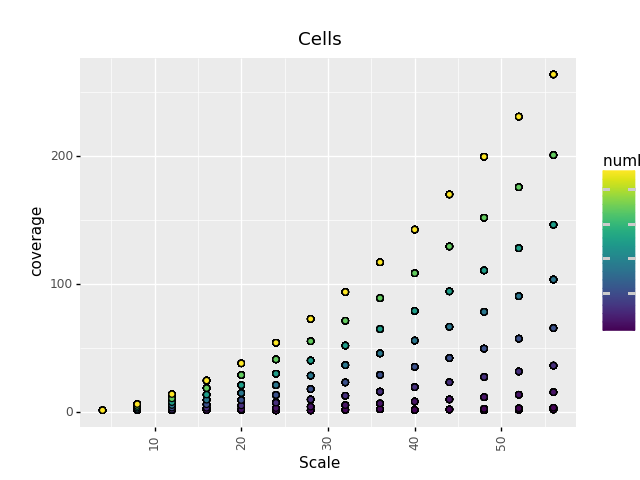

<ggplot: (146205057895)>

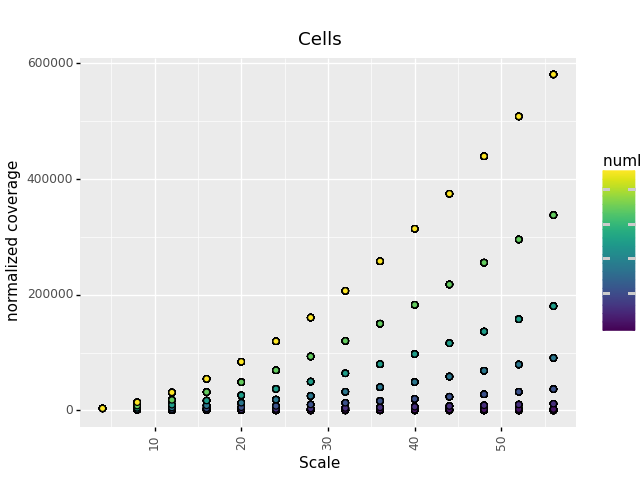

<ggplot: (146108149818)>

In [113]:
# CHOOSE PARAMETERS
density_metrics = ['normalized mean distance density', 'coverage', 'normalized coverage']
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]

traces = [0, 0.7]

o = num_obstacles[0]
t = traces[0]

# function to plot densities:
def plot_all_densities(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims = None):
    p0 = ggplot(data, aes(x_column, y_column, fill = fill_column))
    p0 += geom_point(size=2)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill = x_title
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    if lims is not None:
        p0 += coord_cartesian(ylim=lims)  #+ coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# CREATE FOLDERS FOR EXPERIMENT
folder_density_density = os.path.join(figure_folder, 'density_density/')
make_folder(folder_density_density)


multiples_of = 8

# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')

# plot metrics before continuing
for metric in ['coverage']: #density_metrics:
    # density_scatter = plot_all_densities(experiment_configs, 'scale', metric, 'number of cells', 'Scale', metric, 'Cells')
    # display(density_scatter)
    density_scatter = plot_all_densities(experiment_configs, 'scale', metric, 'number of cells', 'Scale', metric, 'Cells')
    display(density_scatter)
    




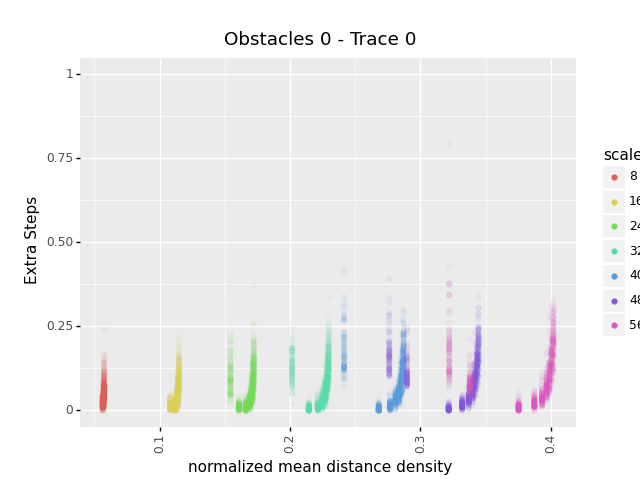

<ggplot: (146201006496)>

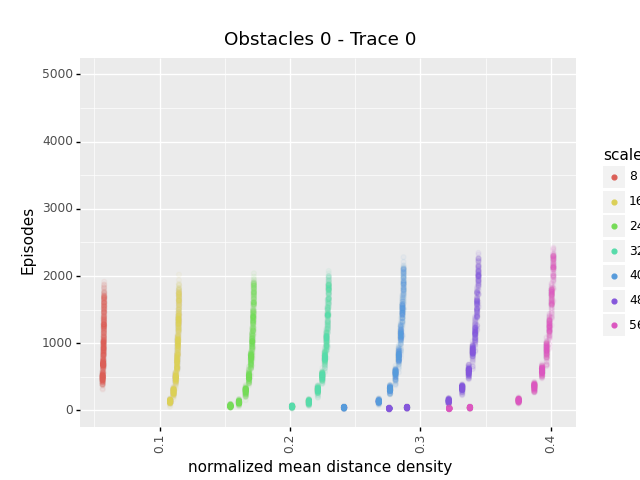

<ggplot: (146103807720)>

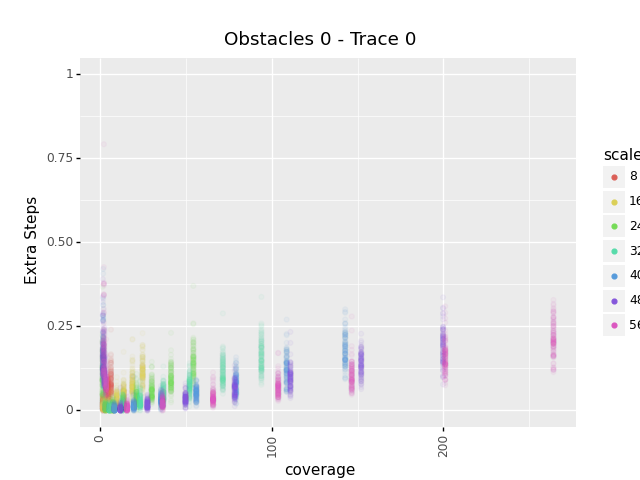

<ggplot: (146104062076)>

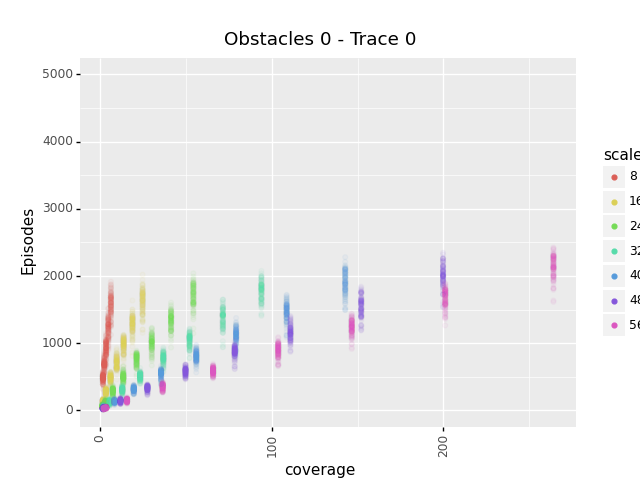

<ggplot: (146106307563)>

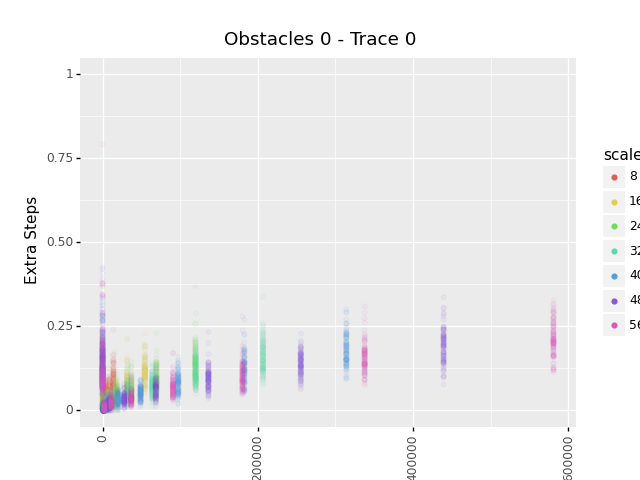

<ggplot: (146106580694)>

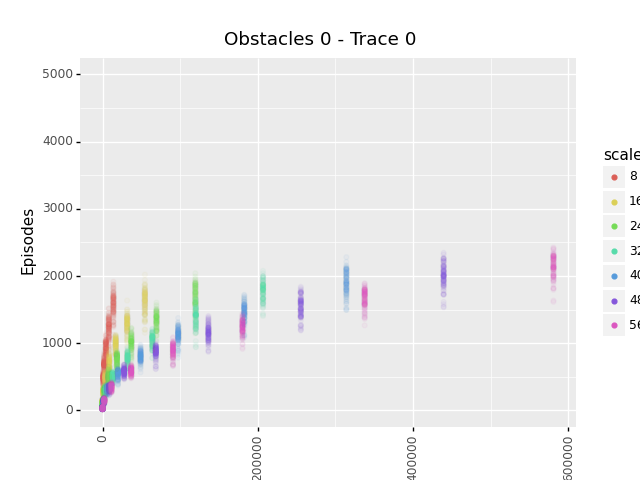

<ggplot: (146107417483)>

In [107]:
experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale % multiples_of == 0)]

# experiment_configs = experiment_configs[(experiment_configs.num_obstacles == o) & (experiment_configs.scale / 12 <= 1)]

# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells'] + density_metrics
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells'] + density_metrics
# display(experiment_configs['number of cells'].unique())
display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(learning_times)




# BOXPLOT FUNCTION
def plot_density_scatter(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims = None):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    # p0 += geom_point(alpha=0.2)
    p0 += geom_jitter(alpha=0.05)
    p0 += labs(x=x_title, y=y_title, title=plot_title) # fill = x_title
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    if lims is not None:
        p0 += coord_cartesian(ylim=lims)  #+ coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    p0 += guides(color = guide_legend(override_aes = {'alpha' : 1} ) )
    return p0
# plt.close('all')

# PLOT
for metric in density_metrics:
    plot_title = f'Obstacles {o} - Trace {t}'
    lims = [0, 1]
    save_name = f'Scatter-Steps-O{o}-T{int(t*10)}-l{lims[1]}-{metric}.pdf'
    # print(f'      PLOT: {save_name}')

    r2 = runtimes_last_episode.copy()
    r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
    r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
    scatter_steps = plot_density_scatter(r2, metric, 'steps', 'scale_d', metric, 'Extra Steps' , plot_title, lims)
    ggsave(scatter_steps, folder_density_density + save_name, dpi=300, verbose = False, width = 10, height =5)


    # PLOT LEARN TIME SCALE
    lims = [0, 5000]
    save_name = f'Scatter-Learn_time-O{o}-T{int(t*10)}-l{lims[1]}-{metric}.pdf'
    # print(f'      PLOT: {save_name}')

    learn_times_2 = learning_times.copy()
    learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
    learn_times_2['scale_d'] = pd.Categorical(learn_times_2['scale'], np.sort(learn_times_2['scale'].unique())) 

    scatter_learn_time = plot_density_scatter(learn_times_2, metric, 'episode', 'scale_d', metric, 'Episodes' , plot_title, lims)
    ggsave(scatter_learn_time, folder_density_density + save_name, dpi=300, verbose = False, width = 10, height =5)


    display(scatter_steps)
    display(scatter_learn_time)


## Density experiment - fixed scale

In [32]:
# CHOOSE PARAMETERS
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]
num_obstacles = [i*10 for i in range(7)]
layers = [f'u{8*i:02d}' for i in range(1,8)]
traces = [0, 0.7]

t = traces[0]
l = layers[6]

# CREATE FOLDERS FOR EXPERIMENT
folder_density_fixed_scale = os.path.join(figure_folder, 'density_fixed_scale/')
make_folder(folder_density_fixed_scale)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == l) & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')


# GET AND AUGMENT DATA
merge_fields = ['num_obstacles', 'scale', 'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

# DISPLAY
fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# display(experiment_configs['number of cells'].unique())
# display(experiment_configs[fields])
# display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
# display(learning_times)


In [33]:
# BOXPLOT FUNCTION
def plot_faceted_box_plot(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
    p0 += facet_grid(f'. ~ {facet_column}', scales='free')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

# plt.close('all')

# PLOT BOXPLOTS SCALE
plot_title = f'Scale {l} - Trace {t}'
lims = [0, 1.5]
save_name = f'Boxplots_Obstacles-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

r2 = runtimes_last_episode.copy()
r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
r2['num_obstacles_d'] = pd.Categorical(r2['num_obstacles'], np.sort(r2['num_obstacles'].unique())) 
box_plot_scale = plot_faceted_box_plot(r2, 'num_cells', 'steps', 'num_obstacles_d', 'Number of cells', 'Extra Steps' , plot_title, lims)
ggsave(box_plot_scale, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME SCALE
lims = [0, 5000]
save_name = f'Learn_time_Obstacles-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

learn_times_2 = learning_times[learning_times.scale > 4].copy()
learn_times_2['num_cells'] = pd.Categorical(learn_times_2['number of cells'], np.sort(learn_times_2['number of cells'].unique())[::-1])
learn_times_2['num_obstacles_d'] = pd.Categorical(learn_times_2['num_obstacles'], np.sort(learn_times_2['num_obstacles'].unique())) 

learn_time_plot_scale = plot_faceted_box_plot(learn_times_2, 'num_cells', 'episode', 'num_obstacles_d', 'Number of Cells', 'Episodes' , plot_title, lims)      
ggsave(learn_time_plot_scale, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT BOXPLOT CELLS
lims = [0, 1.5]
save_name = f'Boxplots_Cells-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = runtimes_last_episode['number of cells'].value_counts()
filtered_runtimes = runtimes_last_episode[runtimes_last_episode['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_runtimes['num_cells'] = pd.Categorical(filtered_runtimes['number of cells'], np.sort(filtered_runtimes['number of cells'].unique())[::-1])
filtered_runtimes['num_obstacles_d'] = pd.Categorical(filtered_runtimes['num_obstacles'], np.sort(filtered_runtimes['num_obstacles'].unique())) 

box_plot_cells = plot_faceted_box_plot(filtered_runtimes, 'num_obstacles_d', 'steps', 'num_cells', 'Obstacles', 'Extra Steps' , plot_title, lims)
ggsave(box_plot_cells, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)


# PLOT LEARN TIME CELLS
lims = [0, 5000]
save_name = f'Learn_Time_Cells-S{l}-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')

counts = learning_times['number of cells'].value_counts()
filtered_learn_times = learning_times[learning_times['number of cells'].isin(counts[counts>100].index)].reset_index(drop=True).copy()
filtered_learn_times['num_cells'] = pd.Categorical(filtered_learn_times['number of cells'], np.sort(filtered_learn_times['number of cells'].unique())[::-1])
filtered_learn_times['num_obstacles_d'] = pd.Categorical(filtered_learn_times['num_obstacles'], np.sort(filtered_learn_times['num_obstacles'].unique())) 

learn_time_plot_cells = plot_faceted_box_plot(filtered_learn_times, 'num_obstacles_d', 'episode', 'num_cells', 'Obstacles', 'Episodes', plot_title, lims)
ggsave(learn_time_plot_cells, folder_density_fixed_scale + save_name, dpi=300, verbose = False, width = 10, height =5)

display(box_plot_scale)
display(learn_time_plot_scale)
display(box_plot_cells)
display(learn_time_plot_cells)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135862072790)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135862691898)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135863374074)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135864467438)>

## Density experiment - best density for each number of obstacles / scale

In [48]:
# CREATE FOLDERS FOR EXPERIMENT
t=0
folder_density_best_densities = os.path.join(figure_folder, 'density_best_densities/')
make_folder(folder_density_best_densities)

# mazes for this experiment
mazes = ['M0'] + [f'M{i}{j:02d}' for i in range(1,7) for j in range(19)]

# FIND BEST NUMBER OF CELLS FOR EACH LAYER FOR EACH OBSTACLE NUMBER:
experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0] == 'u') & (configs.traces == t)].copy()
experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
experiment_configs = pd.merge(experiment_configs.reset_index(), layer_metrics, left_on='pc_files', right_on='layer', how='left').set_index('config')

merge_fields = ['num_obstacles', 'scale', 'maze' ,'number of cells']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location, skip_runtimes= False, skip_summary = False)
if summaries is not None:
    summaries = summaries[summaries.episode == episode].copy().reset_index()

display(summaries, runtimes_last_episode)

,index,config,location,episode,steps,c_id,num_obstacles,scale,maze,number of cells
0,1999,0,255,9995,0.066180,0,0,4,M0,2200
1,3999,2,255,9995,0.022095,2,0,8,M0,609
2,5999,4,255,9995,0.025570,4,0,8,M0,875
3,7999,6,255,9995,0.031647,6,0,8,M0,1230
4,9999,8,255,9995,0.053301,8,0,8,M0,1680
...,...,...,...,...,...,...,...,...,...,...
6278,12557999,12968,255,9995,0.165493,12968,60,56,M609,560
6279,12559999,12970,255,9995,0.147569,12970,60,56,M609,875
6280,12561999,12972,255,9995,0.252957,12972,60,56,M609,1230
6281,12563999,12974,255,9995,0.433825,12974,60,56,M609,1680


,config,location,rat,episode,steps,c_id,num_obstacles,scale,maze,number of cells
0,0,255,0,9995,0.056426,0,0,4,M0,2200
1,0,255,1,9995,0.074347,0,0,4,M0,2200
2,0,255,2,9995,0.034868,0,0,4,M0,2200
3,0,255,3,9995,0.117458,0,0,4,M0,2200
4,0,255,4,9995,0.068105,0,0,4,M0,2200
...,...,...,...,...,...,...,...,...,...,...
72095,12976,255,5,9995,0.599167,12976,60,56,M609,2200
72096,12976,255,6,9995,0.322541,12976,60,56,M609,2200
72097,12976,255,7,9995,0.372708,12976,60,56,M609,2200
72098,12976,255,8,9995,0.903292,12976,60,56,M609,2200


In [78]:
data = runtimes_last_episode
aaa = 0
from scikit_posthocs import posthoc_dunn as dunn_test
pd.options.display.float_format = '{:,.2f}'.format


def find_optimal_num_cells(data):
    # get all number of cells
    num_cells = data['number of cells'].unique()

    # if only one number, return the number
    if len(num_cells) == 1:
        return num_cells[0]
    
    # else, find group with lowest median
    medians = data.groupby(['number of cells'])['steps'].median()
    best_num_cells = medians.idxmin()
    
    # return group with fewest number of cells that does not significantly differ from the group with lowest median
    p_values_dunn = dunn_test(data, val_col='steps', group_col='number of cells', p_adjust='bonferroni', sort = False)
    
#     display(num_cells, medians, medians.idxmin(), p_values_dunn, p_values_dunn.loc[best_num_cells])
    
    for num in num_cells:
        p_val = p_values_dunn.loc[best_num_cells, num]
        if p_val > 0.05: # significance
#             display('Best: ', num)
            return num
    display('ERROR! at least one number of cell should have p_val = 1')
    return -1
    


best_num_cells = data.groupby(['num_obstacles','scale']).apply(find_optimal_num_cells).to_frame('number of cells').reset_index()
display(best_num_cells)


,num_obstacles,scale,number of cells
0,0,4,2200
1,0,8,609
2,0,12,280
3,0,16,165
4,0,20,315
...,...,...,...
93,60,40,140
94,60,44,140
95,60,48,140
96,60,52,140


In [37]:
average_results = runtimes_last_episode.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
average_results

,num_obstacles,scale,number of cells,steps
0,0,4,2200,0.070997
1,0,8,609,0.021908
2,0,8,875,0.025140
3,0,8,1230,0.036208
4,0,8,1680,0.054631
...,...,...,...,...
716,60,56,560,0.190915
717,60,56,875,0.239176
718,60,56,1230,0.306940
719,60,56,1680,0.464560


In [49]:
# FIND BEST NUMBER OF CELLS FOR EACH SCALE AND NUMBER OF OBSTACLES, 
# average_results = summaries.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
average_results = runtimes_last_episode.groupby(['num_obstacles','scale','number of cells']).steps.mean().reset_index()
best_num_cells = average_results.loc[average_results.groupby(['num_obstacles','scale']).steps.idxmin()].reset_index(drop=True)
mean_num_cells = best_num_cells.groupby(['num_obstacles'])['number of cells'].agg(['mean','std']).reset_index()
best_num_cells2 = best_num_cells.loc[best_num_cells.scale % 8 == 0].astype('category')

# display(mean_num_cells)
                                                                         
# PLOTS:
p0 = ggplot(best_num_cells2, aes('num_obstacles', 'number of cells', color='num_obstacles'))
p0 += geom_point(position=position_dodge(width=0.5))
p0 += labs(x='Obstacles', y='Number of cells', color="Obstacles", title=f'Optimal number of cells - Trace {t}')
p0 += facet_grid(". ~ scale")
p0 += scale_color_brewer(type="seq", palette=1, name='Obstacles', limits = (-20,-10, 0, 10, 20, 30, 40, 50, 60), breaks=(0, 10, 20, 30, 40, 50, 60)) 
# p0 += theme_dark()
p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))

p1 = ggplot(best_num_cells2, aes('scale', 'number of cells', color='scale'))
p1 += labs(x='Scale', y='Number of cells', color="Scale", title=f'Optimal number of cells - Trace {t}')
p1 += geom_point(position=position_dodge(width=0.5))
p1 += facet_grid(". ~ num_obstacles")
# p1 += theme_dark()
p1 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))

p2 = ggplot(mean_num_cells, aes('num_obstacles', 'mean'))
p2 += labs(x='Obstacles', y='Number of cells', title=f'Optimal number of cells - Trace {t}')
p2 += geom_point()


ggsave(p0, folder_density_best_densities + f'cells_vs_obstacles_per_scale-T{int(t*10)}.pdf', dpi=300, verbose = False, width=8, height=4)
ggsave(p1, folder_density_best_densities + f'cells_vs_scale_per_obstacles-T{int(t*10)}.pdf', dpi=300, verbose = False, width=8, height=4)
ggsave(p2, folder_density_best_densities + f'cells_vs_obstacles-T{int(t*10)}.pdf', dpi=300, verbose = False)






p3 = ggplot(best_num_cells, aes('factor(num_obstacles)', 'number of cells'))
p3 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
p3 += labs(x='Obstacles')
p3 += coord_cartesian(ylim=[0, 1000])




# p2 += geom_point()
#     p0 = ggplot(data, aes(x_column, y_column, fill=fill_column ))
#     p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=fill_column))

#     p0 += labs(x=x_title, y=y_title, title=plot_title)
#     p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
#     #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
#     # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
#     p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)           
#     return p0

# p2 += theme_dark()


display(p0)
display(p1)
display(p2)
# display(p3)
# display(best_num_cells)
# display(mean_num_cells)
# p0 = ggplot(best_num_cells, aes('num_obstacles', y_column, fill=fill_column ))

# p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
# p0 += labs(x=x_title, y=y_title, title=plot_title)
# p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
# #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
# # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
# p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)           
# return p0


# res = last_episode_summaries.loc[ last_episode_summaries.groupby(['maze', 'scale']).steps.idxmin(), ['maze', 'num_obstacles', 'scale', 'number of cells'] ].copy().reset_index(drop=True)
# display(res)

# plt.close('all')


# p0 += scale_color_discrete()
# p0 += theme(panel_background=element_rect(fill='cyan', alpha=.3))  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135962495823)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135966480336)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (135964482934)>

## CELL CONTRIBUTION

In [28]:
# GET CONFIGURATIONS:
t = 0
configs_multi_layer = configs.loc[configs.pcs.str.contains('ml') & (configs.traces == t)].copy()
configs_multi_layer['num_obstacles'] = configs_multi_layer.maze.map(lambda m : int(m[1])*10).astype('category')

def load_paths(file_paths, num_paths):
    with open( file_paths, 'rb') as file:
        return [load_float_vector(file).reshape((-1, 2)) for i in range(num_paths)]

def filter_turns(paths):
    
    def filter_function(p):
        deltas = p[1:]-p[0:-1] # get delta position (displacement vector)
        is_turn = np.abs(deltas[0:-1]-deltas[1:]).sum(axis=1) > 0.001 # current delta position, must be different to next delta
        return p[1:-1][is_turn] # not only mid points can be turns

    return np.concatenate([filter_function(p) for p in paths])
    
def softmax(matrix):
    # calculate softmax of each row
    # note substracting a constant element does not afect softmax result but helps prevents e^"really big number" = infinity (due to float precision)
    exponential = np.exp(matrix - matrix.max(axis=1).reshape(-1, 1))
    return exponential / exponential.sum(axis=1).reshape(-1,1)
    
    
def activate_place_cells(pcs, positions):
    
    # CONSTANTS - see place cells in java 
    num_cells = len(pcs)
    num_pos   = positions.shape[0]
    
    # FIND DISPLACEMENT VECTOR FOR ALL PCS AND RAT POSITIONS     
    xy = np.repeat(positions, len(pcs), axis=0)          # rat positions to be calculated
    xi = np.tile(pcs[['x', 'y']].to_numpy(),(num_pos,1)) # place cell centers x_i
    deltas = xy - xi
    
    # calculate gaussians and set  activations outside of radius to 0 
    norm2 = np.einsum('ij,ij->i', deltas, deltas).reshape(num_pos, num_cells) # multiply tensors, contract row (calculates norm^2 of each row)
    activations = np.exp(norm2 * pcs['ks'].to_numpy())    
    activations[norm2 > pcs['r2'].to_numpy()] = 0
    
    # normalize and return results 
    return activations / activations.reshape((-1, num_cells)).sum(axis=1).reshape(-1,1)    


def calculate_local_contributions_V(pcs, activations, values):
    # parameters
    num_cells = len(pcs)
    num_positions = int(activations.shape[0])
    
    method = 1
    
    # each method may choose whether:
    # - use abs values
    # - aggregate all locations
    # - choose a normalizer (such as max contrib or sum of contribs)
    if method == 1: # contrib = P_i*V_i 
        # calculate contributions of each place cell, then sum contributions for each position and normalize results
        contributions = activations * np.abs(values) 
#         contributions = activations * values
        normalized_contribs = contributions / (contributions.sum(axis=1) / 100).reshape(-1,1) # note: divide by 100 so that results are in range 0-100 instead of 0-1
        normalized_contribs = normalized_contribs.reshape(-1)
        
        ids = normalized_contribs != 0
        pc_sizes = np.tile(pcs['r'].to_numpy(), num_positions)
        local_contribs = pd.DataFrame({'r':pc_sizes[ids], 'contribution':normalized_contribs[ids]})
        total_contribs = local_contribs.groupby(['r']).sum().reset_index()
        total_contribs.contribution = total_contribs.contribution / num_positions
        return total_contribs
#         return local_contribs
        
        
    elif method == 2: # contrib = P_i*(V_i - V) 
        # calculate V for each position
        init_contribs = activations * values                       # for each position, multiply activation and value of each cell
        value_x = init_contribs.sum(axis=1).reshape(-1,1)          # calculate value function at each position
        relative_contribs = init_contribs - activations * value_x  # calculate the relative contributions of each cell
#         relative_contribs = np.abs(relative_contribs)
#         normalized_contribs = (relative_contribs / np.abs(relative_contribs).max(axis=1).reshape(-1,1)).reshape(-1)*100 # normalize by max activation so that range is always in [0-100], revert matrix back to vector
        normalized_contribs = relative_contribs.reshape(-1)
    
        ids = normalized_contribs != 0
        pc_sizes = np.tile(pcs['r'].to_numpy(), num_positions)
        local_contribs = pd.DataFrame({'r':pc_sizes[ids], 'contribution':normalized_contribs[ids]})
        total_contribs = local_contribs.groupby(['r']).sum().reset_index()
        total_contribs.contribution = total_contribs.contribution / num_positions
        return total_contribs
#         return local_contribs


def calculate_contributions_Q(pcs, p_xi, q_ij):
    r_indices = {str(int(r*100)) : (pcs.r.to_numpy() == r) for r in pcs['r'].unique()}
    rs = set(r_indices.keys()) # 0.04, 0.16, 52
    
    # calculate Q for each scale,total Q and the complement of each scale ( Q - Q_r )
    Q_r_xj = { r : np.einsum('xi,ij->xj', p_xi[:, indices], q_ij[indices]) for r, indices in r_indices.items() } # Q for each scale
    Q_xj = np.sum(list(Q_r_xj.values()), axis = 0) # total Q
    _Q_r_xj = { r : Q_xj - Q_r for r, Q_r in Q_r_xj.items()} # complements
    
    # calculate probabilities of each action:
#     pi_xj = softmax(Q_xj)
#     _pi_r_xj = { r : softmax(Q) for r, Q in _Q_r_xj.items() }
    
    # find best actions for each position in total Q and the complements
    a = Q_xj.argmax(axis=1)
    _a_r = { r : _Q_r.argmax(axis=1) for r, _Q_r in _Q_r_xj.items()}
    
    # we define the contribution of a scale as the number of positions where the action chosen by deactivating the layer difers from the actual action
    num_pos = p_xi.shape[0]
    q_contribs = {r : (a != _a).sum() / num_pos for r, _a in _a_r.items()}
#     q_contribs = {r : (a != _a).sum()  for r, _a in _a_r.items()}
    q_contribs_df = pd.DataFrame(list(q_contribs.items()), columns = ['r','contribution'])
    
    return q_contribs_df
    

def get_pc_contributions_from_rat(pcs, folder, rat, config_id, num_start_locations):
    # PATHS TO DATA
    file_paths = f'{folder}r{rat}-paths.bin'
    file_V = f'{folder}r{rat}-V0.bin'
    file_Q = f'{folder}r{rat}-Q0.bin'
    
    # LOAD DATA
    V_i = load_float_vector(file_V) # load state values
    Q_ij = load_float_matrix(file_Q) # load action values

    # GET POSITIONS IN PATHS AND GET POSITIONS WHERE RAT TURNS
    paths = load_paths(file_paths, num_start_locations)
    all_positions = np.concatenate(paths) # load positions
    turns = filter_turns(paths)
    turns_df = pd.DataFrame({'config':[config_id], 'turns':[len(turns)], 'path length':[len(all_positions)]})
    
    
    # CALCULATE PC ACTIVATIONS
    positions = turns if TURNS_ONLY else all_positions
    activations = activate_place_cells(pcs, positions) # calculate pc activations
    
    
    # CALCULATE V CONTRIBUTIONS
    contributions_v = calculate_local_contributions_V(pcs, activations, V_i)
    contributions_v['config'] = config_id
    
    # CALCULATE Q CONTRIBUTIONS
    contributions_q = calculate_contributions_Q(pcs, activations, Q_ij)
    contributions_q['config'] = config_id

    
    return contributions_v, contributions_q, turns_df
    
def get_pc_contributions_from_config(config_id, config):
    # GET FILE NAMES
    folder_config = os.path.join(folder, 'configs', config_id, '')
    file_pc = config['pc_files']
    num_start_locations = int(config['numStartingPositions'])

    # LOAD PCS, ADD EXTRA FIELDS TO CALCULATE ACTIVATIONS
    pcs = pd.read_csv(file_pc)
    cell_count = pcs.groupby(['r']).count()
    
    tolerance = 0.01
    min_activation = 0.001
    pcs['r_tol'] = pcs['r'] + tolerance
    pcs['r2'] = pcs['r_tol'] ** 2
    pcs['ks'] = np.log(min_activation) / pcs['r2']
    
#     display(pcs)
#     display(cell_count)
      

    # GET CONTRIBUTION OF EACH RAT (use only 10 rats)
    contribs_turns = [get_pc_contributions_from_rat(pcs, folder_config, rat, config['c_id'], num_start_locations) for rat in range(0,10)] # UNDO : range should be 10
    contribs_v, contribs_q, turns = (pd.concat(d).reset_index(drop=True) for d in zip(*contribs_turns))
    return contribs_v, contribs_q, turns
    
def get_contribs(turns_only):
    global TURNS_ONLY
    TURNS_ONLY = turns_only
    # display(get_pc_contributions_from_config('c13044', configs_multi_layer.loc['c13044'])) # UNDO: replace line with next line
    config_contribs_and_turns = [get_pc_contributions_from_config(config_id, config) for config_id, config in configs_multi_layer.iterrows()]
    config_contributions_v, config_contributions_q, config_turns = ( concat_augment(d)  for d in zip(*config_contribs_and_turns))
    config_contributions_v['r_d'] = (config_contributions_v.r * 100).astype('int').astype('category')
    config_contributions_q['r_d'] = (config_contributions_v.r * 100).astype('int').astype('category')
    
    return config_contributions_v, config_contributions_q, config_turns
    
# for each config, load pcs, for each rat load V, Q and paths during last episode, finally compute contribution of each non zero pc
concat_augment = lambda data : augment_data(pd.concat(data).reset_index(drop=True), configs_multi_layer, ['maze', 'num_obstacles'])


config_contributions_v_turns, config_contributions_q_turns, config_turns = get_contribs(turns_only=True)
config_contributions_v_all, config_contributions_q_all, config_turns = get_contribs(turns_only=False)

# CREATE FOLDERS FOR EXPERIMENT
folder_contributions = os.path.join(figure_folder, 'contributions/')
make_folder(folder_contributions)

# configs
# display(config_contributions_v)
# display(config_contributions_q)
# display(configs_multi_layer)
display('Done')

'Done'

In [29]:

def plot_box_plot_turns(data, x_column, y_column, fill_column, x_title, y_title, plot_title):
    p0 = ggplot(data, aes(x_column, y_column, fill=fill_column ))
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=fill_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)       
    return p0

def plot_box_plot2(data, x_column, y_column, facet_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
    p0 += facet_grid(f'. ~ {facet_column}', scales='free')
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)
    p0 += theme(axis_text_x=element_text(rotation=90, hjust=0.5))
    return p0

plt.close('all')


maxy = config_contributions_v_turns.contribution.max()
miny = config_contributions_v_turns.contribution.min()
buffer = 0.1*(maxy-miny)
lims = [miny - buffer, maxy+buffer]
# lims = [0, 120]

def plot_title(trace, turns_only):
    return ("Turns only - " if turns_only else "All positions - ") + f'Trace {trace}'

# save_name = f'Boxplots_Scale-T{int(t*10)}-l{lims[1]}.pdf'
# print(f'      PLOT: BOXPLOT - {save_name}')
# r2 = runtimes_last_episode[runtimes_last_episode.scale > 4].copy()
# r2['num_cells'] = pd.Categorical(r2['number of cells'], np.sort(r2['number of cells'].unique())[::-1])
# r2['scale_d'] = pd.Categorical(r2['scale'], np.sort(r2['scale'].unique())) 
# box_plot_scale = plot_box_plot(r2, 'scale_d', 'steps', 'num_cells', 'PC Radius (cm)', 'Extra Steps', 'Number of Cells' , plot_title, lims)
box_plot_scale_turns = plot_box_plot2(config_contributions_v_turns, 'num_obstacles', 'contribution', 'r_d', 'Obstacles', 'Value contribution' , plot_title(t, True), lims)
box_plot_scale_q_turns = plot_box_plot2(config_contributions_q_turns, 'num_obstacles', 'contribution', 'r_d', 'Obstacles', 'Action contribution' , plot_title(t, True), [0, 0.3])

box_plot_scale_all = plot_box_plot2(config_contributions_v_all, 'num_obstacles', 'contribution', 'r_d', 'Obstacles', 'Value contribution' , plot_title(t, False), lims)
box_plot_scale_q_all = plot_box_plot2(config_contributions_q_all, 'num_obstacles', 'contribution', 'r_d', 'Obstacles', 'Action contribution' , plot_title(t, False), [0, 0.3])

# box_plot_obstacles = plot_box_plot2(config_contributions, 'r_d', 'contribution', 'num_obstacles', 'Scale', 'Contribution' , plot_title, lims)

# difference:
config_contributions_v_turns['diff'] = config_contributions_v_turns.contribution - config_contributions_v_all.contribution
config_contributions_q_turns['diff'] = config_contributions_q_turns.contribution - config_contributions_q_all.contribution

box_plot_scale_diff = plot_box_plot2(config_contributions_v_turns, 'r_d', 'diff', 'num_obstacles', 'Scale', 'Value contribution' , 'Difference', [-25,25])
box_plot_scale_q_diff = plot_box_plot2(config_contributions_q_turns, 'r_d', 'diff', 'num_obstacles', 'Scale', 'Action contribution' , 'Difference', [-0.2, 0.2])


box_plot_turns = plot_box_plot_turns(config_turns, 'num_obstacles', 'turns', 'num_obstacles', 'Obstacles', 'Turns' , "Path turns")
box_plot_lengths = plot_box_plot_turns(config_turns, 'num_obstacles', 'path length', 'num_obstacles', 'Obstacles', 'Path length' , "Path length")

t_val = int(t*10)
ggsave(box_plot_scale_turns,   folder_contributions + f'v_contribs_turns-t{t_val}.pdf', dpi=300, verbose = False)
ggsave(box_plot_scale_q_turns, folder_contributions + f'q_contribs_turns-t{t_val}.pdf', dpi=300, verbose = False)

ggsave(box_plot_scale_all,   folder_contributions + f'v_contribs_all-t{t_val}.pdf', dpi=300, verbose = False)
ggsave(box_plot_scale_q_all, folder_contributions + f'q_contribs_all-t{t_val}.pdf', dpi=300, verbose = False)

ggsave(box_plot_scale_diff,   folder_contributions + f'v_contribs_diff-t{t_val}.pdf', dpi=300, verbose = False)
ggsave(box_plot_scale_q_diff, folder_contributions + f'q_contribs_diff-t{t_val}.pdf', dpi=300, verbose = False)


ggsave(box_plot_turns, folder_contributions + 'turns.pdf', dpi=300, verbose = False)
ggsave(box_plot_lengths, folder_contributions + 'steps.pdf', dpi=300, verbose = False)


display(box_plot_scale_turns)
display(box_plot_scale_q_turns)

display(box_plot_scale_all)
display(box_plot_scale_q_all)

# display(box_plot_obstacles)
display(box_plot_turns)
display(box_plot_lengths)
# ggsave(box_plot_scale, folder_density_obstacle_num + save_name, dpi=300, verbose = False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106314646757)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106314646742)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106329458062)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106329474356)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106329495215)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106329499435)>

In [92]:
# GET AND AUGMENT DATA
merge_fields = ['num_obstacles']
episode = lastEpisode(configs_multi_layer, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, configs_multi_layer, merge_fields, episode, location, skip_summary=True)
runtimes_last_episode = runtimes_last_episode.loc[runtimes_last_episode.rat < 10]

display(runtimes_last_episode)

p = ggplot(runtimes_last_episode, aes('num_obstacles', 'steps', fill='num_obstacles')) + labs(x='obstacles', y='extra steps', fill='obstacles', title='Extra step ratios')
p += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group='num_obstacles'))
p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)

ggsave(p , folder_contributions + 'extra_steps.pdf')

#     p0 = ggplot(data, aes(x_column, y_column, fill=x_column ))
#     p0 += facet_grid(f'. ~ {facet_column}', scales='free')
#     p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=x_column))
#     p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
#     p0 += labs(x=x_title, y=y_title, title=plot_title, fill=x_title)
#     p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
p



,config,location,rat,episode,steps,c_id,num_obstacles
0,13044,255,0,9995,0.010870,13044,10
1,13044,255,1,9995,0.072752,13044,10
2,13044,255,2,9995,0.033784,13044,10
3,13044,255,3,9995,0.044121,13044,10
4,13044,255,4,9995,0.084736,13044,10
...,...,...,...,...,...,...,...
5905,13162,255,5,9995,0.061899,13162,60
5906,13162,255,6,9995,0.087432,13162,60
5907,13162,255,7,9995,0.105591,13162,60
5908,13162,255,8,9995,0.061899,13162,60


c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/contributions/extra_steps.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106336099509)>

In [91]:
# statistical significance:

from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn as dunn_test


k1 = kruskal(*[group["turns"].values for name, group in config_turns.groupby("num_obstacles")])
k2 = kruskal(*[group["path length"].values for name, group in config_turns.groupby("num_obstacles")])
k3 = kruskal(*[group["steps"].values for name, group in runtimes_last_episode.groupby("num_obstacles")])

dunn1=dunn_test(config_turns, val_col='turns', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
dunn2=dunn_test(config_turns, val_col='path length', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
dunn3=dunn_test(runtimes_last_episode, val_col='steps', group_col='num_obstacles', p_adjust='bonferroni', sort = False)

display(f'LENGTHS, k={k2}')
display(dunn2)


display(f'TURNS, k={k1}')
display(dunn1)

display(f'Extra steps, k={k3}')
display(dunn3)





display('ALL')
for scale, scale_data in config_contributions_v_all.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    print(f'scale {scale}, kruskal: {k}')
    display(dunn)

display('TURNS')
for scale, scale_data in config_contributions_v_turns.groupby(['r_d']):
    k = kruskal(*[group["contribution"].values for name, group in scale_data.groupby("num_obstacles")])
    
    dunn = dunn_test(scale_data, val_col='contribution', group_col='num_obstacles', p_adjust='bonferroni', sort = False)
    
    print(f'scale {scale}, kruskal: {k}')
    display(dunn)
    




'LENGTHS, k=KruskalResult(statistic=110.70259180756413, pvalue=2.9107725745477535e-22)'

,10,20,30,40,50,60
10,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,2.363092e-10,7.539073e-11
20,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.112927e-10,3.489115e-11
30,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,5.787240e-09,1.994752e-09
40,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,3.262034e-06,1.335380e-06
50,2.363092e-10,1.112927e-10,5.787240e-09,0.000003,1.000000e+00,1.000000e+00
60,7.539073e-11,3.489115e-11,1.994752e-09,0.000001,1.000000e+00,1.000000e+00


'TURNS, k=KruskalResult(statistic=103.58052135681444, pvalue=9.290266219847954e-21)'

,10,20,30,40,50,60
10,1.000000,1.162790e-02,1.000000e+00,1.000000,7.969859e-05,2.827097e-06
20,0.011628,1.000000e+00,3.130638e-02,0.000153,3.752956e-14,1.527335e-16
30,1.000000,3.130638e-02,1.000000e+00,1.000000,1.987405e-05,5.883473e-07
40,1.000000,1.526288e-04,1.000000e+00,1.000000,6.975943e-03,4.806220e-04
50,0.000080,3.752956e-14,1.987405e-05,0.006976,1.000000e+00,1.000000e+00
60,0.000003,1.527335e-16,5.883473e-07,0.000481,1.000000e+00,1.000000e+00


'Extra steps, k=KruskalResult(statistic=120.52117325432711, pvalue=2.434100149711815e-24)'

,10,20,30,40,50,60
10,1.000000e+00,1.000000e+00,1.000000e+00,2.463452e-01,2.036566e-13,5.075034e-14
20,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.013070e-08,6.652700e-09
30,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.006383e-10,5.876449e-11
40,2.463452e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.728490e-06,6.506952e-07
50,2.036566e-13,2.013070e-08,2.006383e-10,1.728490e-06,1.000000e+00,1.000000e+00
60,5.075034e-14,6.652700e-09,5.876449e-11,6.506952e-07,1.000000e+00,1.000000e+00


'ALL'

scale 4, kruskal: KruskalResult(statistic=40.97566389351073, pvalue=9.489598429647261e-08)


,10,20,30,40,50,60
10,1.000000,1.000000,1.000000,1.000000,0.000076,0.008393
20,1.000000,1.000000,1.000000,1.000000,0.000005,0.000969
30,1.000000,1.000000,1.000000,1.000000,0.006877,0.250811
40,1.000000,1.000000,1.000000,1.000000,0.001495,0.081462
50,0.000076,0.000005,0.006877,0.001495,1.000000,1.000000
60,0.008393,0.000969,0.250811,0.081462,1.000000,1.000000


scale 16, kruskal: KruskalResult(statistic=76.4395054908482, pvalue=4.656915549153357e-15)


,10,20,30,40,50,60
10,1.000000,1.317384e-01,1.000000e+00,1.000000,1.394960e-03,1.445244e-03
20,0.131738,1.000000e+00,1.000000e+00,0.060070,9.959709e-10,1.054543e-09
30,1.000000,1.000000e+00,1.000000e+00,0.664253,2.241955e-07,2.356661e-07
40,1.000000,6.006988e-02,6.642533e-01,1.000000,3.921659e-03,4.054531e-03
50,0.001395,9.959709e-10,2.241955e-07,0.003922,1.000000e+00,1.000000e+00
60,0.001445,1.054543e-09,2.356661e-07,0.004055,1.000000e+00,1.000000e+00


scale 52, kruskal: KruskalResult(statistic=20.297320465890152, pvalue=0.0010989169195386298)


,10,20,30,40,50,60
10,1.000000,0.526962,0.004500,1.000000,0.003848,0.348475
20,0.526962,1.000000,1.000000,1.000000,1.000000,1.000000
30,0.004500,1.000000,1.000000,0.179086,1.000000,1.000000
40,1.000000,1.000000,0.179086,1.000000,0.159592,1.000000
50,0.003848,1.000000,1.000000,0.159592,1.000000,1.000000
60,0.348475,1.000000,1.000000,1.000000,1.000000,1.000000


'TURNS'

scale 4, kruskal: KruskalResult(statistic=53.27590682196319, pvalue=2.952005589805245e-10)


,10,20,30,40,50,60
10,1.000000,1.000000e+00,1.000000,1.000000e+00,0.028229,1.333320e-06
20,1.000000,1.000000e+00,0.904859,1.000000e+00,0.021443,8.527006e-07
30,1.000000,9.048587e-01,1.000000,2.393380e-01,1.000000,5.777858e-03
40,1.000000,1.000000e+00,0.239338,1.000000e+00,0.002987,3.784699e-08
50,0.028229,2.144299e-02,1.000000,2.986856e-03,1.000000,3.765337e-01
60,0.000001,8.527006e-07,0.005778,3.784699e-08,0.376534,1.000000e+00


scale 16, kruskal: KruskalResult(statistic=38.068609650582175, pvalue=3.655367080123157e-07)


,10,20,30,40,50,60
10,1.000000,1.000000,1.000000,1.000000,0.000970,0.570891
20,1.000000,1.000000,1.000000,0.537125,0.000020,0.053020
30,1.000000,1.000000,1.000000,0.258439,0.000005,0.020640
40,1.000000,0.537125,0.258439,1.000000,0.092525,1.000000
50,0.000970,0.000020,0.000005,0.092525,1.000000,0.821276
60,0.570891,0.053020,0.020640,1.000000,0.821276,1.000000


scale 52, kruskal: KruskalResult(statistic=49.504475873543925, pvalue=1.7501224439051317e-09)


,10,20,30,40,50,60
10,1.000000,1.000000,0.071426,9.414198e-01,1.000000,3.892879e-04
20,1.000000,1.000000,0.116372,6.489067e-01,1.000000,7.813550e-04
30,0.071426,0.116372,1.000000,4.228084e-05,0.040911,1.000000e+00
40,0.941420,0.648907,0.000042,1.000000e+00,1.000000,1.952013e-08
50,1.000000,1.000000,0.040911,1.000000e+00,1.000000,1.775869e-04
60,0.000389,0.000781,1.000000,1.952013e-08,0.000178,1.000000e+00


In [79]:
def plot_box_plot(data, x_column, y_column, fill_column, x_title, y_title, plot_title, lims):
    p0 = ggplot(data, aes(x_column, y_column, fill=fill_column ))
    p0 += geom_jitter(alpha=0.3, position=position_jitterdodge(), mapping=aes(group=fill_column))
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p0 += labs(x=x_title, y=y_title, title=plot_title)
    p0 += theme(axis_text_x=element_text(rotation=45, hjust=0.5))
    #     p0 += p0 + scale_fill_brewer(type="seq", palette=1, name=legend_title)
    # p0 += scale_fill_brewer(type="qual", palette=1, name=legend_title)
    p0 += coord_cartesian(ylim=lims)  + coord_fixed(ratio=0.1)           
    return p0

plot_box_plot(runtimes_last_episode, 'num_obstacles', 'steps', 'num_obstacles', 'Obstacles', 'Extra steps', 'Multiscale', [0, 0.5])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106334795867)>

In [125]:
config_turns

,config,turns,path length,c_id,maze,num_obstacles
0,13045,31,116,13045,M100,10
1,13045,32,113,13045,M100,10
2,13045,31,110,13045,M100,10
3,13045,38,114,13045,M100,10
4,13045,37,112,13045,M100,10
...,...,...,...,...,...,...
595,13163,41,120,13163,M609,60
596,13163,41,113,13163,M609,60
597,13163,47,119,13163,M609,60
598,13163,40,118,13163,M609,60


## Optimal paths

In [93]:
maze_metrics_file = 'experiments/mazes/mazeMetrics.csv'
maze_metrics = pd.read_csv(maze_metrics_file)
mazes = [f'M{i}{j:02d}.xml' for i in range(1,7) for j in range(19)]
maze_metrics = maze_metrics.loc[maze_metrics.maze.isin(mazes)][['maze','pos','steps']].copy().reset_index(drop=True)

maze_metrics2 = maze_metrics.groupby(['maze']).steps.sum().reset_index()
maze_metrics2['num_obstacles'] = maze_metrics2.maze.map(lambda s : s[1:-5])

# display(maze_metrics2)

# print('Min steps')
# display(maze_metrics.groupby(['pos']).steps.min())

# print('Max steps')
# display(maze_metrics.groupby(['pos']).steps.max())
noise = 0.1
p = ggplot(maze_metrics2, aes('num_obstacles', 'steps', color='num_obstacles')) + geom_jitter(width=noise, height = noise) + labs(color = 'obstacles', x='obstacles', title='Optimal paths')
ggsave(p,figure_folder + 'optimal_paths_plot.pdf')
# print()
display(p)

# filter_mazes#
# maze_metrics.groupby(['pos'])

c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\users\bucef\appdata\local\programs\python\python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: experiments/BICY2020_modified/logs/experiment11-article2/figures/optimal_paths_plot.pdf


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (106332327578)>